## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import torchvision
import numpy as np
import skimage.io
from skimage.measure import find_contours
import colorsys
import random

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from models import models_mae
from data.datasets import clip_ct_window_cube_root
import nibabel as nib
import torchio as tio
from data.preprocessing import RescaleIntensityCubeRoot

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')


### Define utils

In [2]:
# define the utils

mean = np.array([0])
std = np.array([1])

def show_image(image, title=''):
    # image is [H, W]
    assert len(image.shape) == 2
    plt.imshow(torch.clip((image * std + mean) * 255, 0, 255).int(), cmap='gray')
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_3d_vit_base'):
    # build model
    model = getattr(models_mae, arch)(norm_pix_loss=True, in_chans=1, patch_size=(16,16,2), img_size=(224,224,4))
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_volume(vol, model):
    
    model.to('cuda')
    
    grid_sampler = tio.inference.GridSampler(vol, patch_size=(224,224,4))
    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=1)
    aggregator_data = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')
    aggregator_mask = tio.inference.GridAggregator(grid_sampler)
    
    #sampler = tio.UniformSampler(patch_size=64)
    #patches_queue = tio.Queue(
    #    dataset, 20, 20, sampler, num_workers=4
    #)

    # run MAE
    tot_loss = torch.zeros(1)
    tot_loss = tot_loss.to('cuda')
    i = 0
    with torch.no_grad():
        for patches_batch in patch_loader:
            input_tensor = patches_batch['t1'][tio.DATA]
            input_tensor = input_tensor.to('cuda', non_blocking=True)
            print("Input shape: {}".format(input_tensor.shape))
            locations = patches_batch[tio.LOCATION]
            loss, y, mask = model(input_tensor, mask_ratio=0.75)
            print("Y shape: {}".format(y.shape))
            tot_loss += loss
            outputs = model.unpatchify_3d(y)
            print("Unpatchified shape: {}".format(outputs.shape))
            mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**3 *1)
            mask = model.unpatchify_3d(mask)
            aggregator_data.add_batch(outputs, locations)
            aggregator_mask.add_batch(mask, locations)
            i += 1
    print("Number of batches: {}".format(i))
    print("Average loss is: {}".format(tot_loss / i))
    output_tensor = aggregator_data.get_output_tensor()
    mask_tensor = aggregator_mask.get_output_tensor()

    print(output_tensor.shape)
    print(output_tensor.min())
    print(output_tensor.max())
    print(mask_tensor.shape)
    print(mask_tensor.min())
    print(mask_tensor.max())

    x = vol['t1'][tio.DATA][0,:,:,0].detach().cpu()
    y = output_tensor[0,:,:,0].detach().cpu()
    m = mask_tensor[0,:,:,0].detach().cpu()

    # masked image
    im_masked = x * (1 - m)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - m) + y * m

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 6, 1)
    show_image(x, "original")

    plt.subplot(1, 6, 2)
    show_image(im_masked, "masked")

    plt.subplot(1, 6, 3)
    show_image(y, "reconstruction")

    plt.subplot(1, 6, 4)
    show_image(im_paste, "reconstruction + visible")

    plt.show()

def get_transform():
    voxel_spacing = (0.8, 0.8, 2)
    ct_min = -1000
    ct_max = 1000

    vs = tio.Resample(voxel_spacing)
    rs = RescaleIntensityCubeRoot(out_min_max=(0, 1), in_min_max=(ct_min, ct_max), cube_rooted=True)
    transform_list = [vs, rs]
    transform = tio.Compose(transform_list)
    return transform

### Load and show an original image

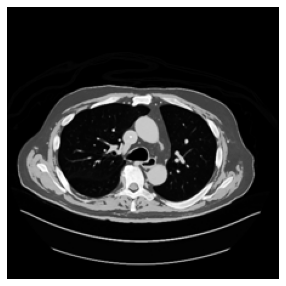

In [3]:
# load a nifti file
nifti_path = 'D:/Datasets/DeepLesion/Images_nifti/000033_02_01_113-125.nii.gz'
nifti_path = 'D:/Datasets/DeepLesion/Images_nifti/000030_01_01_193-253.nii.gz'
nifti_path = 'D:/Datasets/DeepLesion/Images_nifti/003463_01_01_103-628.nii.gz'
data = nib.load(nifti_path)
org_data = data.get_fdata()

org_img_data = clip_ct_window_cube_root(org_data, -1000, 1000)
first_slice = org_img_data[:,:,3]
nifti_img = Image.fromarray(first_slice)
nifti_img = nifti_img.convert('L')
nifti_img = nifti_img.resize((224, 224))
nifti_img = np.array(nifti_img) / 255.

assert nifti_img.shape == (224, 224)

# normalize by ImageNet mean and std
nifti_img = nifti_img - mean
nifti_img = nifti_img / std

img = nifti_img


plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(nifti_img))

## Load and transform volume

In [4]:
transform = get_transform()
subject_volume = tio.Subject(t1=tio.ScalarImage(nifti_path))
trans_volume = transform(subject_volume)
print(trans_volume.shape)
print(trans_volume['t1'][tio.DATA].min())
print(trans_volume['t1'][tio.DATA].max())


(1, 514, 514, 263)
tensor(-0.0040)
tensor(1.1180)


### Load a pre-trained MAE model

In [5]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist

chkpt_dir = 'D:/Models/MAE/pretrain-3d/size224-224-4-w16-16-2/checkpoint-2.pth'
model_mae = prepare_model(chkpt_dir, 'mae_3d_vit_base')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the volume

MAE with pixel reconstruction:
Input shape: torch.Size([1, 1, 224, 224, 4])
Y shape: torch.Size([1, 392, 512])
torch.Size([1, 392, 512])
torch.Size([1, 14, 14, 2, 16, 16, 2, 1])
torch.Size([1, 1, 224, 224, 4])
Unpatchified shape: torch.Size([1, 1, 224, 224, 4])
torch.Size([1, 392, 4096])
torch.Size([1, 14, 14, 2, 16, 16, 2, 8])
torch.Size([1, 8, 224, 224, 4])
Input shape: torch.Size([1, 1, 224, 224, 4])
Y shape: torch.Size([1, 392, 512])
torch.Size([1, 392, 512])
torch.Size([1, 14, 14, 2, 16, 16, 2, 1])
torch.Size([1, 1, 224, 224, 4])
Unpatchified shape: torch.Size([1, 1, 224, 224, 4])
torch.Size([1, 392, 4096])
torch.Size([1, 14, 14, 2, 16, 16, 2, 8])
torch.Size([1, 8, 224, 224, 4])
Input shape: torch.Size([1, 1, 224, 224, 4])
Y shape: torch.Size([1, 392, 512])
torch.Size([1, 392, 512])
torch.Size([1, 14, 14, 2, 16, 16, 2, 1])
torch.Size([1, 1, 224, 224, 4])
Unpatchified shape: torch.Size([1, 1, 224, 224, 4])
torch.Size([1, 392, 4096])
torch.Size([1, 14, 14, 2, 16, 16, 2, 8])
torch.Si

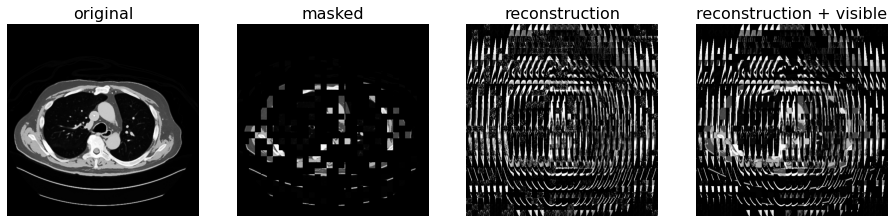

In [6]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_volume(trans_volume, model_mae)

In [7]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return


In [8]:
def attn_one_image(img, model):
    threshold = 0.25
    patch_size = 16
    output_dir = 'attn'
    w, h = img.shape[0] - img.shape[0] % patch_size, img.shape[1] - img.shape[1] % patch_size

    w_featmap = img.shape[1] // patch_size
    h_featmap = img.shape[0] // patch_size
    
    x = torch.tensor(img)
    img_tensor = torch.tensor(x)
    
    # Expand image from H*W to H*W*1
    x = x.unsqueeze(dim=2)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    attentions = model.get_last_selfattention(x.float())

    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    if threshold is not None:
        # we keep only a certain percentage of the mass
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        # interpolate
        th_attn = torch.nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = torch.nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    # save attentions heatmaps
    os.makedirs(output_dir, exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img_tensor, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
    for j in range(nh):
        fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        print(f"{fname} saved.")

    if threshold is not None:
        image = skimage.io.imread(os.path.join(output_dir, "img.png"))
        for j in range(nh):
            display_instances(image, th_attn[j], fname=os.path.join(output_dir, "mask_th" + str(threshold) + "_head" + str(j) +".png"), blur=False)
            
    

In [9]:
print('MAE Attention:')
attn_one_image(img, model_mae)

MAE Attention:


C:\Users\David\AppData\Local\Temp/ipykernel_11568/4106149494.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(x)


IndexError: tuple index out of range